# Sentiment Analysis for "Coco (2017)" Based on Subtitles Using TextBlop

#### Rizky Nurhidayat | 17/10/2023

Coco is a 2017 Mexican-American 3D computer-animated musical fantasy comedy-drama film produced by Pixar Animation Studios and released by Walt Disney Pictures. Based on an original idea by Lee Unkrich, it is directed by him and co-directed by Adrian Molina. The film's voice cast stars Anthony Gonzalez, Gael García Bernal, Benjamin Bratt, Alanna Ubach, Renée Victor, Ana Ofelia Murguía, and Edward James Olmos. The story follows a 12-year-old boy named Miguel who is accidentally transported to the Land of the Dead, where he seeks the help of his deceased musician great-great-grandfather to return him to his family among the living and to reverse his family's ban on music. (https://disney.fandom.com/)

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. (https://textblob.readthedocs.io/)

## Aim of the project

The goal of this project is to analyze the sentiment of subtitle text from the movie "Coco (2017)" using the Natural Language Processing (NLP) tool TextBlob. Through this analysis, I aim to understand how the audience's emotions evolve throughout the film and create compelling visualizations of the sentiment analysis results.

## Steps of the project

### Data Collection
In this stage, I collected text data from the subtitles of the movie "Coco (2017)" by extracting the text from .srt files that contain the subtitles. The subtitle text will serve as the basis for our sentiment analysis.

### Data Preprocessng
During this stage, I cleaned the collected subtitle data, removed unnecessary characters, and processed the data, such as spliting timestamps and formatting them correctly. The purpose of this step is to ensure that the data used for sentiment analysis is ready for analysis.

### Exploratory Analysis
This stage is the core of the project. I conducted sentiment analysis using TextBlob, allowing me to assess whether the subtitle text has positive, negative, or neutral sentiments. Additionally, I generated visualizations of sentiment trends per minute, enabling us to observe how the audience's feelings change throughout the movie. I also compared the frequency of negative and positive sentiments at each minute to gain further insights. Finally, I created a word cloud visualization based on movie quotes to understand the most common keywords in the subtitle text.

In [1]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from matplotlib.collections import LineCollection
from wordcloud import WordCloud
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')



### 1. Data Collection

In [2]:
# Function to read subtitles from a .srt file and return a list of subtitle blocks
def read_srt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.read().split('\n\n')
    return lines

# Function to retrieve the time (timestamp) and text of each subtitle blocks
def extract_time_and_text(subtitle_blocks):
    lines = subtitle_blocks.strip().split('\n')
    if len(lines) >= 3:
        time = lines[1]
        text = ' '.join(lines[2:])
        return time, text
    else:
        return None, None

In [4]:
# Reading .srt files
srt_file_path = 'Coco.2017.srt'
subtitle_blocks = read_srt_file(srt_file_path)

# Create a DataFrame from a list of times and quotes
time_list = []
subtitle_list = []
for block in subtitle_blocks:
    time, text = extract_time_and_text(block)
    if time is not None and text is not None:
        time_list.append(time)
        subtitle_list.append(text)

df = pd.DataFrame({'time': time_list, 'subtitle': subtitle_list})
df.head()

,time,subtitle
0,"00:00:45,516 --> 00:00:48,832",(BELL TOLLING)
1,"00:01:09,639 --> 00:01:12,009","MIGUEL: <i>Sometimes, I think I'm cursed.</i>"
2,"00:01:12,011 --> 00:01:15,644",<i>Because of something that happened before I...
3,"00:01:15,646 --> 00:01:18,997","<i>See, a long time ago, there was this family..."
4,"00:01:20,152 --> 00:01:23,020","<i>The</i> papa, <i>he was a musician.</i>"


### 2. Preprocessing Data

In [5]:
# Function to clean subtitle and convert them to lowercase
def clean_subtitle(subtitle):
    # Remove <i> and </i> tags
    subtitle = re.sub(r'<i>|</i>', '', subtitle)
    # Remove ♪ characters
    subtitle = subtitle.replace('♪', '')
    # Remove '\n' characters
    subtitle = subtitle.replace('\n', '')
    # Remove punctuations
    subtitle = re.sub(r'[^\w\s]', '', subtitle)
    # Convert subtitle to lowercase
    return subtitle.lower()

# Apply the cleaning function to the 'quotee' column
df['subtitle'] = df['subtitle'].apply(clean_subtitle)

# Display the cleaned dataframe
df.tail()


,time,subtitle
1717,"01:38:25,863 --> 01:38:31,601",and know that im with you the only way that i...
1718,"01:38:31,603 --> 01:38:36,506",so until youre on my arms again
1719,"01:38:36,508 --> 01:38:38,489",remember me
1720,"01:38:42,247 --> 01:38:46,697",remember me
1721,"01:38:47,786 --> 01:38:50,802",remember me


In [6]:
# Function to convert time string to seconds
def time_to_seconds(time_str):
    time_parts = re.split(r'[:,.]', time_str)
    hours, minutes, seconds, fractions = map(int, time_parts)
    return hours * 3600 + minutes * 60 + seconds + fractions / 1000

# Parse the 'time' column to get start and end times
df['start_time'] = df['time'].apply(lambda x: time_to_seconds(x.split(' --> ')[0]))
df['end_time'] = df['time'].apply(lambda x: time_to_seconds(x.split(' --> ')[1]))

# Calculate approximate time for each chunk
df['approximate_time'] = (df['start_time'] + df['end_time']) / 2

# Function to find the closest time in the 'approximate_time' column
def find_closest_time(approx_time, time_values):
    return min(time_values, key=lambda x: abs(x - approx_time))

# Find the exact time for each chunk and calculate the distance
df['exact_time'] = df['approximate_time'].apply(lambda x: find_closest_time(x, df['start_time']))
df['time_distance'] = abs(df['exact_time'] - df['approximate_time'])

# Konversi nilai 'exact_time' dari detik ke menit
df['exact_time_in_minutes'] = df['exact_time'] / 60

# Display the updated dataframe
df.head()

,time,subtitle,start_time,end_time,approximate_time,exact_time,time_distance,exact_time_in_minutes
0,"00:00:45,516 --> 00:00:48,832",bell tolling,45.516,48.832,47.1740,45.516,1.6580,0.758600
1,"00:01:09,639 --> 00:01:12,009",miguel sometimes i think im cursed,69.639,72.009,70.8240,69.639,1.1850,1.160650
2,"00:01:12,011 --> 00:01:15,644",because of something that happened before i wa...,72.011,75.644,73.8275,72.011,1.8165,1.200183
3,"00:01:15,646 --> 00:01:18,997",see a long time ago there was this family,75.646,78.997,77.3215,75.646,1.6755,1.260767
4,"00:01:20,152 --> 00:01:23,020",the papa he was a musician,80.152,83.020,81.5860,80.152,1.4340,1.335867


### 3. Exploratory Analysis

In [7]:
# Function to analyze sentiment and calculate sentiment score
def analyze_sentiment(text):
    analysis = TextBlob(text)
    score = analysis.sentiment.polarity
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Negative' if analysis.sentiment.polarity < 0 else 'Neutral'    
    return score, sentiment

df['score'], df['sentiment']= zip(*df['subtitle'].apply(analyze_sentiment))

df.tail()


,time,subtitle,start_time,end_time,approximate_time,exact_time,time_distance,exact_time_in_minutes,score,sentiment
1717,"01:38:25,863 --> 01:38:31,601",and know that im with you the only way that i...,5905.863,5911.601,5908.7320,5905.863,2.8690,98.431050,0.0,Neutral
1718,"01:38:31,603 --> 01:38:36,506",so until youre on my arms again,5911.603,5916.506,5914.0545,5911.603,2.4515,98.526717,0.0,Neutral
1719,"01:38:36,508 --> 01:38:38,489",remember me,5916.508,5918.489,5917.4985,5916.508,0.9905,98.608467,0.0,Neutral
1720,"01:38:42,247 --> 01:38:46,697",remember me,5922.247,5926.697,5924.4720,5922.247,2.2250,98.704117,0.0,Neutral
1721,"01:38:47,786 --> 01:38:50,802",remember me,5927.786,5930.802,5929.2940,5927.786,1.5080,98.796433,0.0,Neutral


In [8]:
print(df.info())
print(df['sentiment'].value_counts())
print(df['score'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   1722 non-null   object 
 1   subtitle               1722 non-null   object 
 2   start_time             1722 non-null   float64
 3   end_time               1722 non-null   float64
 4   approximate_time       1722 non-null   float64
 5   exact_time             1722 non-null   float64
 6   time_distance          1722 non-null   float64
 7   exact_time_in_minutes  1722 non-null   float64
 8   score                  1722 non-null   float64
 9   sentiment              1722 non-null   object 
dtypes: float64(7), object(3)
memory usage: 134.7+ KB
None
sentiment
Neutral     1337
Positive     246
Negative     139
Name: count, dtype: int64
count    1722.000000
mean        0.031182
std         0.209737
min        -1.000000
25%         0.000000
50%         0.0000

#### Trend Line Sentiment Score Over Times

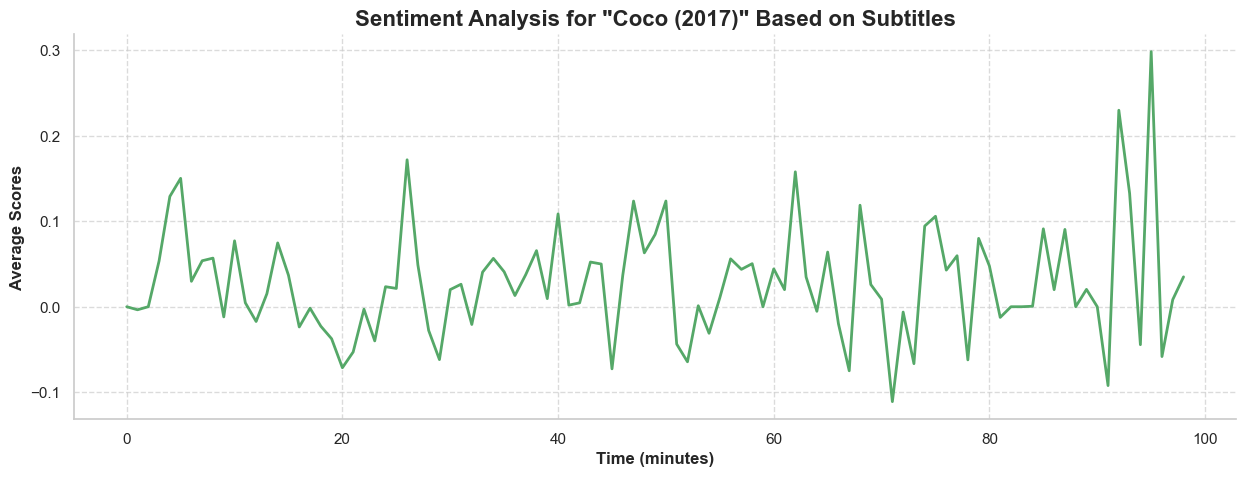

In [12]:
# Convert column 'exact_time_in_minutes' into int data type
df['exact_time_in_minutes'] = df['exact_time_in_minutes'].astype(int)

# Aggregation of average scores at each time interval
score_trend = df.groupby('exact_time_in_minutes')['score'].mean().reset_index()

# Plot with Seaborn
plt.figure(figsize=(15, 5))
sns.set(style="whitegrid")

# Plot a trend line
plot = sns.lineplot(data=score_trend, x='exact_time_in_minutes', y='score', color='g', linewidth=2)

sns.despine()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Sentiment Analysis for "Coco (2017)" Based on Subtitles', fontsize=16, fontweight='bold')
plt.xlabel('Time (minutes)', fontweight='bold')
plt.ylabel('Average Scores', fontweight='bold')

plt.show()


The line graph illustrates the changing sentiments throughout the film "Coco (2017)," with the X-axis representing time in minutes and the Y-axis displaying the average sentiment score. The early minutes of the film exhibit a neutral sentiment, as they primarily serve as an introductory phase in which little emotional content is introduced. A shift occurs around the 5-minute mark when the sentiment becomes more positive during Miguel's monologue about Ernesto de La Cruz. This upbeat sentiment is short-lived, giving way to negativity as the film recounts the moment when Ernesto meets his demise under a giant bell. The sentiment fluctuates over time, with a negative spike around the 20-minute mark when Miguel steals Ernesto's guitar from a museum. Notably, sentiment peaks positively between minutes 24 and 27, coinciding with the introduction of the spirit world "Land of The Dead" and its various features. However, it subsequently dips between minutes 28 and 30, corresponding to a moment of tension when Mama Imelda struggles to cross a bridge due to Miguel bringing her photo into the spirit realm, incurring a curse, because he stole that guitar.

The sentiment rollercoaster continues, and a significant positive peak is observed around minute 40 when Miguel and Hector journey to Ernesto de La Cruz's gladiatorial arena. Around minute 45, the sentiment turns negative as Hector sings his poignant farewell song to Chicharrón with his guitar. The sentiment surges positively again between minutes 58 and 60 as Miguel's performance on guitar captivates the grand party audience, particularly Ernesto. A climactic moment unfolds between minutes 65 and 75, with sentiment taking a deep dive into negativity. This period encompasses Miguel's discovery that Ernesto plagiarized Hector's songs and was responsible for his murder. Miguel and Hector are subsequently banished, and the revelation that Hector is Miguel's great-great-grandfather adds emotional complexity.

Sentiment takes another dip between minutes 85 and 91, as Coco, Hector's daughter, nearly forgets him. However, it makes a poignant upturn as Miguel's rendition of "Remember Me" triggers Coco's recollection of Hector, her father. One year later, Miguel proudly presents the family ofrenda – which now features Hector and a photo of the recently-deceased Coco – to his new baby sister (who's named after Coco).

This comprehensive analysis highlights the dynamic emotional landscape of "Coco (2017)," offering insights into the film's storytelling and character development as sentiment shifts in response to key narrative moments.

#### Distribution of The Positive and Negative Sentiments

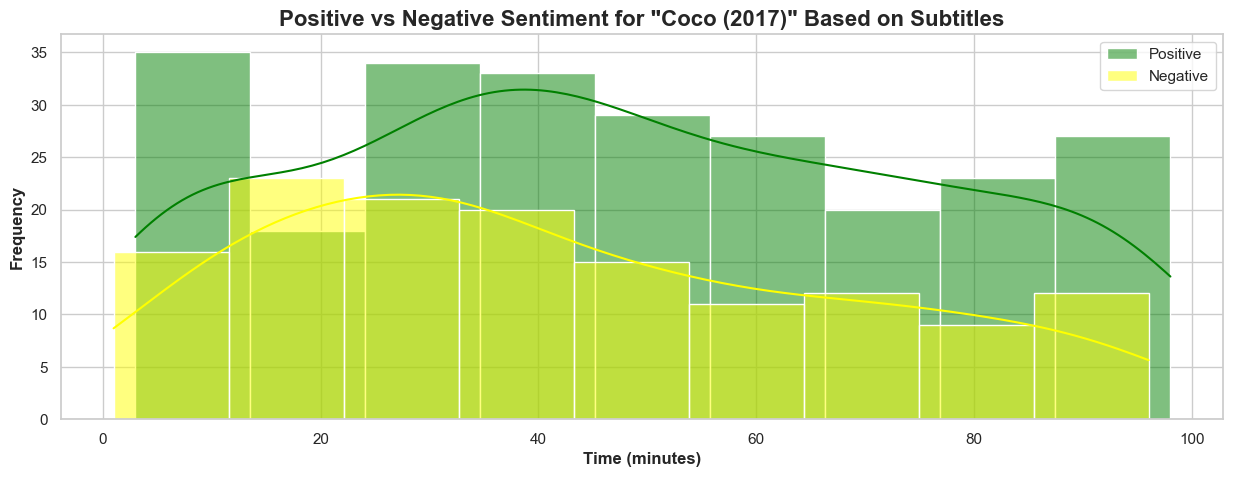

In [11]:
# Filter data based on “Positive” and “Negative” sentiment
positive_sentiment = df[df['sentiment'] == 'Positive']
negative_sentiment = df[df['sentiment'] == 'Negative']

# Create a plot for sentiment comparison
plt.figure(figsize=(15, 5))
sns.set(style="whitegrid")

# Histogram for “Positive” and “Negative” sentiment
sns.histplot(data=positive_sentiment, x='exact_time_in_minutes', color='green', label='Positive', kde=True)
sns.histplot(data=negative_sentiment, x='exact_time_in_minutes', color='yellow', label='Negative', kde=True)

plt.title('Positive vs Negative Sentiment for "Coco (2017)" Based on Subtitles', fontsize=16, fontweight='bold')
plt.xlabel('Time (minutes)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.legend()
plt.show()


The graph depicts the positive and negative sentiments for the movie "Coco (2017)." It features a histogram with the X-axis representing time in minutes and the Y-axis representing frequency. In this histogram, two distinct colors are used: green and yellow, where green signifies positive sentiment and yellow represents negative sentiment. Notably, the green bars consistently appear higher than the yellow ones throughout the duration of the film.

Analyzing the peaks in the graph, the highest point of green bars is observed between minutes 35 and 45. This peak corresponds to a pivotal moment when Miguel, the film's main character with dreams of becoming a renowned musician, passionately encounters Ernesto de la Cruz, a famous musician. This moment likely represents a positive turning point or a high emotional peak in the film.

In contrast, the peak in the yellow bars occurs between minutes 20 and 30. This period signifies a different moment in the story when Miguel is on the verge of despair, as he doesn't possess a guitar. In his desperation, he decides to steal Ernesto's guitar. During this same timeframe, Miguel first enters and becomes trapped in the world of spirits, a moment of great fear as he encounters living skeletons for the first time.

Overall, the graph reveals that positive sentiment predominates throughout the film.

#### WordCloud of The Subtitles

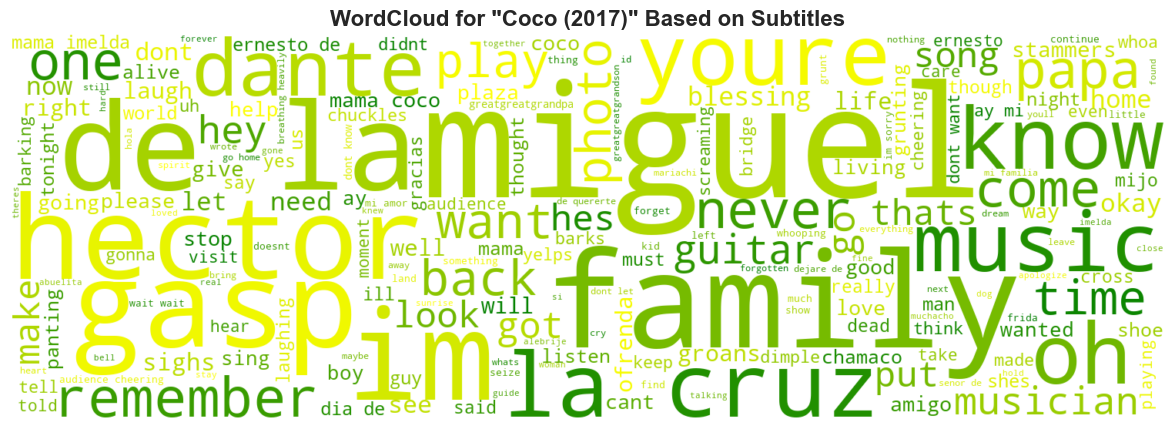

In [13]:
# Combine all subtitle text into one string
all_text = " ".join(df['subtitle'])

# Create a gradient colormap
colors = ['green', 'yellow']
cmap = LinearSegmentedColormap.from_list('green_to_yellow', colors, N=256)

# Create a WordCloud with a gradient colormap
wordcloud = WordCloud(width=1500, height=500, background_color='white', colormap=cmap).generate(all_text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud for "Coco (2017)" Based on Subtitles', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()


The word cloud generated from subtitles in the film "Coco (2017)" provides a visual representation of the most frequently mentioned words, with word size indicating their relative frequency or importance within the movie's dialogue.

Prominently featured in the word cloud is the name "Miguel," which is the film's central character. This reflects the character's significant presence and his pivotal role in the story. The emphasis on "family" in the word cloud underscores one of the core themes of the film - the importance of family bonds, heritage, and traditions.

"Hector" is another large word in the word cloud, reflecting his significance as a key character in the film. The word cloud also prominently features "music," which is a central element of the film's narrative. The emphasis on "de La Cruz" suggests the importance of Ernesto de La Cruz as a character in the film, particularly in relation to the story's conflict.

The presence of "gasp" in the word cloud is intriguing, as it indicates a moment of surprise or shock, which may represent key plot twists or emotionally charged scenes in the film. "Remember" is a significant word, resonating with the film's theme of remembrance and the power of music to evoke memories.

In summary, the word cloud analysis highlights the film's core elements and themes, with a focus on Miguel, family, Hector, music, Ernesto de La Cruz, moments of surprise ("gasp"), and the idea of remembrance. These words capture the essence of the film's narrative and its emotional depth, showcasing the central characters, key themes, and memorable moments in "Coco (2017)."

## Conclussion

By completing this project, I gained insights into how sentiments in the movie "Coco (2017)" evolve throughout the film. The sentiment analysis results provide insights into how the audience perceives different moments in the movie, and the visualizations created help illustrate these findings in an engaging way. This project can serve as a foundation for a better understanding of the audience's reactions to the film and the role of sentiment in the narrative of the movie.